In [1]:
!pip install tqdm scikit-learn scikit-image matplotlib opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires onnxruntime<2,>=1.15.0, which is not installed.
autogluon-multimodal 1.4.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is n

In [2]:
# =========================================
# Parasite Image Classification - Linear SVM
# Using Preprocessed CLEAN Dataset (Raw Pixels)
# =========================================

import os, cv2, joblib
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# ----- 1. Paths and parameters -----
output_dir = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/parasite_output/data/clean"
IMG_SIZE = (48, 48)
MODEL_PATH = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/svm_clean.pkl"
SCALER_PATH = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/scaler_clean.pkl"

# ----- 2. Load images -----
def load_images_full(data_dir):
    X, y, labels = [], [], set()
    subsets = ["train", "val", "test"]
    for subset in subsets:
        subset_path = os.path.join(data_dir, subset)
        if not os.path.isdir(subset_path):
            continue
        class_names = sorted(os.listdir(subset_path))
        for label in class_names:
            folder = os.path.join(subset_path, label)
            if not os.path.isdir(folder):
                continue
            files = [f for f in os.listdir(folder)
                     if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            for file in tqdm(files, desc=f"{subset}/{label}", ncols=80):
                img_path = os.path.join(folder, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.resize(gray, IMG_SIZE)
                X.append(gray.flatten())
                y.append(label)
                labels.add(label)
    labels = sorted(list(labels))
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    y = np.array([label_to_idx[lab] for lab in y])
    return np.array(X), y, labels

# ----- 3. Train Linear SVM -----
def train_svm_linear(X_train, y_train):
    print("Training Linear SVM...")
    model = LinearSVC(C=1.0, loss='squared_hinge', dual=False, max_iter=2000, verbose=1)
    model.fit(X_train, y_train)
    print("Training completed.")
    return model

# ----- 4. Main -----
if __name__ == "__main__":
    X, y, labels = load_images_full(output_dir)
    print(f"\nLoaded {len(X)} images from {len(labels)} classes.")
    print(f"Feature dimension: {X.shape[1]}")

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Standardize
    scaler = StandardScaler().fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

    # Train model
    model = train_svm_linear(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Save model and scaler
    joblib.dump(model, MODEL_PATH)
    joblib.dump(scaler, SCALER_PATH)
    print(f"\nModel saved to: {MODEL_PATH}")
    print(f"Scaler saved to: {SCALER_PATH}")


test/trypanosome: 100%|██████████████████████| 477/477 [00:02<00:00, 236.58it/s]



Loaded 23927 images from 7 classes.
Feature dimension: 2304
Training Linear SVM...
[LibLinear]iter  1 act 1.712e+04 pre 1.699e+04 delta 9.119e-01 f 1.914e+04 |g| 7.674e+04 CG  12
iter  2 act 3.011e+02 pre 2.219e+02 delta 9.119e-01 f 2.023e+03 |g| 1.312e+04 CG  15
cg reaches trust region boundary
iter  3 act 3.896e+02 pre 3.206e+02 delta 1.166e+00 f 1.722e+03 |g| 5.479e+03 CG  42
cg reaches trust region boundary
iter  4 act 2.383e+02 pre 1.926e+02 delta 1.549e+00 f 1.332e+03 |g| 1.559e+03 CG  40
cg reaches trust region boundary
iter  5 act 1.646e+02 pre 1.396e+02 delta 1.919e+00 f 1.094e+03 |g| 1.528e+03 CG  39
cg reaches trust region boundary
iter  6 act 1.092e+02 pre 1.131e+02 delta 1.919e+00 f 9.292e+02 |g| 1.128e+03 CG  42
iter  7 act 4.220e+01 pre 4.121e+01 delta 1.919e+00 f 8.200e+02 |g| 2.772e+03 CG  21
cg reaches trust region boundary
iter  8 act 5.551e+01 pre 6.630e+01 delta 1.919e+00 f 7.779e+02 |g| 5.367e+02 CG  40
cg reaches trust region boundary
iter  9 act 5.091e+01 pre 8

In [4]:
# =========================================
# Common Evaluation Function
# Equivalent to MATLAB evaluate_model.m
# =========================================

import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_model(y_true, y_pred, labels):
    """
    Evaluate classification results.

    Parameters
    ----------
    y_true : array-like
        True class labels (list or numpy array)
    y_pred : array-like
        Predicted class labels (list or numpy array)
    labels : list of str
        Ordered list of class names

    Returns
    -------
    results : dict
        {
            "Accuracy": float,
            "Precision": float,
            "Recall": float,
            "F1": float,
            "ConfusionMatrix": np.ndarray,
            "Labels": list
        }
    """

    # Ensure numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix with fixed label order
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Accuracy
    acc = np.trace(cm) / np.sum(cm)

    # Precision (per class)
    prec = np.diag(cm) / np.maximum(np.sum(cm, axis=1), 1)
    # Recall (per class)
    rec = np.diag(cm) / np.maximum(np.sum(cm, axis=0), 1)
    # F1 (per class)
    f1 = 2 * (prec * rec) / np.maximum(prec + rec, np.finfo(float).eps)

    # Macro averages
    results = {
        "Accuracy": acc,
        "Precision": np.nanmean(prec),
        "Recall": np.nanmean(rec),
        "F1": np.nanmean(f1),
        "ConfusionMatrix": cm,
        "Labels": labels
    }

    # Print summary
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {results['Precision']*100:.2f}%  "
          f"Recall: {results['Recall']*100:.2f}%  "
          f"F1: {results['F1']*100:.2f}%")

    return results


In [6]:
# ======================================================
# Part 2: EVALUATION
# ======================================================
print("\n=== EVALUATION PHASE ===")

# Load saved model and scaler (optional if already in memory)
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# Use test set from train_test_split above
y_pred = model.predict(X_test)

# Convert integer labels back to names
y_true_names = [labels[i] for i in y_test]
y_pred_names = [labels[i] for i in y_pred]

# Evaluate
print("\n=== Evaluation on CLEAN Dataset ===")
results = evaluate_model(y_true_names, y_pred_names, labels)

print("\nConfusion Matrix:")
print(results["ConfusionMatrix"])


=== EVALUATION PHASE ===

=== Evaluation on CLEAN Dataset ===
Accuracy: 65.75%
Precision: 55.29%  Recall: 55.86%  F1: 54.93%

Confusion Matrix:
[[ 168    2   14    2    9   35    5]
 [  30  135   16   38    3  236   82]
 [  32    3   47    8   22   55    1]
 [   1    2    9  246   39  219   71]
 [   0    0    0    1  750    1    0]
 [  47  162   51   96    1 1601   69]
 [  24   42    7   41    3  160  200]]


Loading model and scaler...

=== Evaluating degraded datasets ===

gaussian_blur_s1.0         Accuracy: 81.41%
gaussian_blur_s2.0         Accuracy: 80.03%
gaussian_noise_s15         Accuracy: 43.13%
gaussian_noise_s5          Accuracy: 69.46%
jpeg_q20                   Accuracy: 74.30%
jpeg_q40                   Accuracy: 77.53%
jpeg_q60                   Accuracy: 79.57%
motion_blur_k5             Accuracy: 80.95%
resolution_x2              Accuracy: 80.97%
resolution_x4              Accuracy: 78.68%

=== Summary of Model Robustness ===


,Degradation,Accuracy
0,gaussian_blur_s1.0,81.410390
8,resolution_x2,80.972251
7,motion_blur_k5,80.951387
1,gaussian_blur_s2.0,80.033382
6,jpeg_q60,79.574379
9,resolution_x4,78.677238
5,jpeg_q40,77.529731
4,jpeg_q20,74.295848
3,gaussian_noise_s5,69.455456
2,gaussian_noise_s15,43.125391


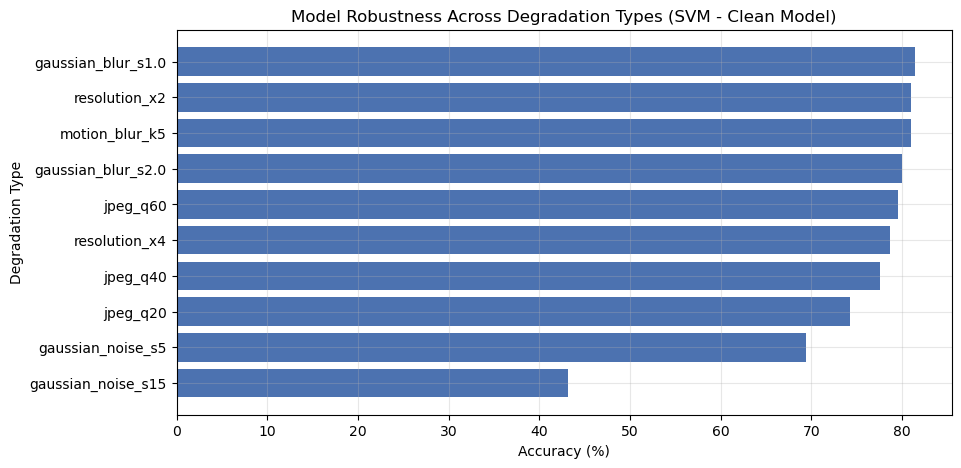

In [8]:
# =========================================
# Evaluate Linear SVM on All Degraded Datasets
# =========================================

import os, cv2, joblib, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# ----- Paths -----
DEG_DIR = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/parasite_output/data/degraded"
MODEL_PATH = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/svm_clean.pkl"
SCALER_PATH = "/mnt/custom-file-systems/efs/fs-0a4ab4658fce5fcd7_fsap-036152789f9bb0438/42177/scaler_clean.pkl"
IMG_SIZE = (48, 48)

# ----- Helper: load test set -----
def load_images_for_eval(data_dir):
    X, y, labels = [], [], set()
    subset_path = os.path.join(data_dir, "test")
    if not os.path.isdir(subset_path):
        return None, None, None, None
    class_names = sorted(os.listdir(subset_path))
    for label in class_names:
        folder = os.path.join(subset_path, label)
        if not os.path.isdir(folder):
            continue
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        for file in files:
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, IMG_SIZE)
            X.append(gray.flatten())
            y.append(label)
            labels.add(label)
    if len(X) == 0:
        return None, None, None, None
    labels = sorted(list(labels))
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    y_idx = np.array([label_to_idx[lab] for lab in y])
    return np.array(X), y_idx, labels, y

# ----- Load model and scaler -----
print("Loading model and scaler...")
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# ----- Evaluate all degraded folders -----
results_summary = []
degradations = sorted(os.listdir(DEG_DIR))

print("\n=== Evaluating degraded datasets ===\n")
for d in degradations:
    test_path = os.path.join(DEG_DIR, d)
    if not os.path.isdir(test_path):
        continue

    X, y_idx, labels, y_true_names = load_images_for_eval(test_path)
    if X is None:
        continue

    X_scaled = scaler.transform(X)
    y_pred_idx = model.predict(X_scaled)
    y_pred_names = [labels[i] for i in y_pred_idx]

    acc = accuracy_score(y_true_names, y_pred_names)
    results_summary.append({"Degradation": d, "Accuracy": acc * 100})

    print(f"{d:<25s}  Accuracy: {acc*100:.2f}%")

# ----- Display summary table -----
print("\n=== Summary of Model Robustness ===")
df_results = pd.DataFrame(results_summary).sort_values(by="Accuracy", ascending=False)
display(df_results)

# ----- Optional: plot bar chart -----
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(df_results["Degradation"], df_results["Accuracy"], color="#4C72B0")
plt.xlabel("Accuracy (%)")
plt.ylabel("Degradation Type")
plt.title("Model Robustness Across Degradation Types (SVM - Clean Model)")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()
